# KNN - Scikit learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


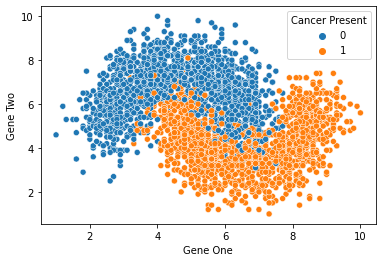

In [5]:
sns.scatterplot(x='Gene One', y='Gene Two', data=df, hue='Cancer Present');

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
scaler = StandardScaler()

In [18]:
scaled_X_train = scaler.fit_transform(X_train)

In [19]:
scaled_X_test = scaler.transform(X_test)

## Import the KNN algorithm from sklearn

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [22]:
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [23]:
y_pred = knn_model.predict(scaled_X_test)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

In [25]:
confusion_matrix(y_test, y_pred)

array([[420,  50],
       [ 47, 383]])

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



## To choose the best value for k

We can setup a pipeline in scikit learn.
- Can setup sequence of repeated operations (scaler and model)
- Only pipeline needs to be called after that

### Manual (Elbow method)

In [27]:
from sklearn.metrics import accuracy_score

In [29]:
error = 1 - accuracy_score(y_test, y_pred)
error

0.10777777777777775

In [32]:
test_error_rates = []
    
for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_Train, y_train)

    y_pred_test = knn_model.predict(scaled_X_test)
    test_error = 1 - accuracy_score(y_test, y_pred_test)

    test_error_rates.append(test_error)

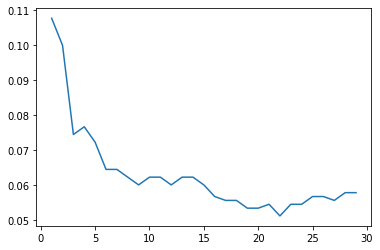

In [34]:
sns.lineplot(x=np.array(range(1,30)), y=test_error_rates);

## Setting up a scikit learn pipeline

### Creating a Pipeline to find K value

**Follow along very carefully here! We use very specific string codes AND variable names here so that everything matches up correctly. This is not a case where you can easily swap out variable names for whatever you want!**

We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

----
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data

----

In [35]:
scaler = StandardScaler()

In [36]:
knn = KNeighborsClassifier()

In [38]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

### Define the operations

In [39]:
operations = [('scaler', scaler), ('knn', knn)]

In [40]:
from sklearn.pipeline import Pipeline

In [41]:
pipe = Pipeline(operations)

In [42]:
from sklearn.model_selection import GridSearchCV

In [44]:
k_values = list(range(1,20))

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [50]:
param_grid = {'knn__n_neighbors': k_values}

### Setup gridsearch

In [51]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [52]:
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

## Checking the best parameters

In [54]:
full_cv_classifier.best_params_

{'knn__n_neighbors': 14}

In [55]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=14),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 14,
 'knn__p': 2,
 'knn__weights': 'uniform'}

# Final Model

In [57]:
full_pred = full_cv_classifier.predict(X_test)

In [58]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



Performance has increased for k=14

In [59]:
from joblib import dump

In [60]:
dump(full_cv_classifier, 'knn_gene_classifier.joblib')

['knn_gene_classifier.joblib']